Estimate parameters for resempling procedure (trial generation).

* Number of resampling iterations: M is based on bootstrapping stability analysis 
* Number of trials per resampling: N = 40 (based on data in monkey dataset so the number of trials is from experiments)

#### Bootstrapping Stability Analysis (for M)

We determine a reasonable M by checking when the mean stabilizes:

1. Compute the cumulative mean of intrinsic timescales as M increases.
2. Plot the standard error (SE) of the mean vs. M.
3. Pick M where SE flattens out.

Start with M = 20 ([20,30,40,50,100])

#### Selecting number of signals for M estimate

Spike trains are coming from different brain areas and may have different variance so using only one is not gut. 

We use sequential testing: (incrementally add signals until the estimate stabilizes):

1. Start with 5 random signals and determine an initial M.
2. Add 5 more signals, recompute M, and compare.
3. Repeat until the change in M is minimal (e.g., <2%).

In [2]:
import csv
import sys
import pickle
import numpy as np
import pandas as pd
import random
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# import from scripts
import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
#os.chdir(os.path.abspath("C:\\Users\\ipoch\\Documents\\repos\\isttc\\scripts"))
from calculate_tau import fit_single_exp, func_single_exp_monkey
from cfg_global import project_folder_path
from calculate_acf import acf_pearsonr_trial_avg, acf_sttc_trial_avg, acf_sttc_trial_concat
from spike_train_utils import bin_spike_train_fixed_len, get_trials, bin_trials
os.chdir(current_wd)

In [3]:
dataset_folder = project_folder_path + 'results\\allen_mice\\dataset\\cut_30min\\'

### Get data

In [4]:
csv_data_file = dataset_folder + 'sua_list_constrained.csv'
with open(csv_data_file, newline='') as f:
    reader = csv.reader(f)
    sua_list = list(reader)
print(f'Loaded N units {len(sua_list)}')

Loaded N units 5775


### Estimate M

In [14]:
fs = 30000
signal_len = int(30 * 60 * fs)
n_lags = 20
bin_size = 50 # in ms
trial_len = int(n_lags * bin_size * (fs/1000))

n_trials = 40 # this is fixed based on experimental datasets
m_iterations = [20, 40, 60, 80, 100, 150, 200, 500, 1000]

n_signals = 10

In [15]:
random_signals = random.sample(sua_list, n_signals)

In [16]:
output_log = dataset_folder + f'resampling//resampling_params_estimate_{n_signals}_signals.txt'
old_stdout = sys.stdout
sys.stdout = open(output_log, 'w')

signal_tau_dict = {}

for signal_idx, signal in enumerate(random_signals):
    print(f'###\nCalculating for {signal_idx} signal')
    spikes = np.asarray([int(spike) for spike in signal[8:]])

    tau_dict = {}
    for m_iteration in m_iterations:
        print(f'calculating for {m_iteration} resampling iterations')
        tau_l = []
        for m in range(m_iteration):
            spikes_trials = get_trials(spikes, signal_len, n_trials, trial_len, verbose_=False)
            spikes_trials_binned = bin_trials(spikes_trials, trial_len, int(bin_size*(fs/1000)))
            # get taus
            _, acf_average = acf_pearsonr_trial_avg(spikes_trials_binned, n_lags, verbose_=False)
            _, _, tau, _, _, _, _ = fit_single_exp(acf_average, start_idx_=1, exp_fun_=func_single_exp_monkey)
            tau_l.append(tau)
        tau_dict[m_iteration] = tau_l
        
    signal_tau_dict[signal_idx] = tau_dict

with open(dataset_folder + f'resampling//signal_tau_dict_{n_signals}_signals.pkl', "wb") as f:
    pickle.dump(signal_tau_dict, f)

sys.stdout = old_stdout

In [17]:
signal_tau_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [30]:
# Lists to store values for tau_df
signal_l = []
m_iterations_l = []
tau_nanmean_l = []
sem_tau_l = []

# Process signal_tau_dict into tau_df
for k, v in signal_tau_dict.items():
    for kk, vv in v.items():
        vv_ = [tau_ for tau_ in vv if tau_ < 100]  # Filtering extreme values
        tau = np.nanmean(vv_)
        tau_sem = stats.sem(vv_, nan_policy='omit')  # Handle NaNs properly
        signal_l.append(k)
        m_iterations_l.append(kk)
        tau_nanmean_l.append(tau)
        sem_tau_l.append(tau_sem)

# Create tau_df
tau_df = pd.DataFrame({
    "signal": signal_l,
    "m_iterations": m_iterations_l,
    "tau_nanmean": tau_nanmean_l,
    'tau_sem': sem_tau_l
})

# Check the stabilization of SE
threshold = 0.05  # 5% threshold for stabilization
stabilization_list = []

for signal in tau_df["signal"].unique():
    # Filter data for the current signal and sort by m_iterations
    signal_data = tau_df.query('signal == @signal').sort_values(by='m_iterations')

    # Extract SEM values and corresponding m_iterations
    sem_tau_values = signal_data['tau_sem'].values
    m_iterations_values = signal_data['m_iterations'].values

    # Find stabilization point
    stabilization_point = np.nan  # Default to NaN if no stabilization is found
    for i in range(1, len(sem_tau_values)):
        change = abs(sem_tau_values[i] - sem_tau_values[i-1])
        if change < threshold:
            stabilization_point = m_iterations_values[i]
            break  # Stop checking after finding the first stabilization point

    stabilization_list.append({"signal": signal, "stabilization_point": stabilization_point})

# Create stabilization_df
stabilization_df = pd.DataFrame(stabilization_list)

# Display the final DataFrames
print(tau_df.head())         # First few rows of tau_df
print(stabilization_df.head())  # First few rows of stabilization_df

   signal  m_iterations  tau_nanmean   tau_sem
0       0            20     0.032359  0.005786
1       0            40     0.025581  0.001829
2       0            60     0.412586  0.383107
3       0            80     0.268747  0.147068
4       0           100     0.191942  0.119015
   signal  stabilization_point
0       0                 40.0
1       1                  NaN
2       2                  NaN
3       3                150.0
4       4                  NaN


In [31]:
stabilization_df

,signal,stabilization_point
0,0,40.0
1,1,NaN
2,2,NaN
3,3,150.0
4,4,NaN
5,5,NaN
6,6,100.0
7,7,NaN
8,8,150.0
9,9,NaN


In [27]:
tau_df

,signal,m_iterations,tau_nanmedian,tau_sem
0,0,20,0.032359,0.005786
1,0,40,0.025581,0.001829
2,0,60,0.412586,0.383107
3,0,80,0.268747,0.147068
4,0,100,0.191942,0.119015
...,...,...,...,...
85,9,100,7.285013,1.511848
86,9,150,6.896255,0.990796
87,9,200,7.763024,0.939952
88,9,500,6.949070,0.443712


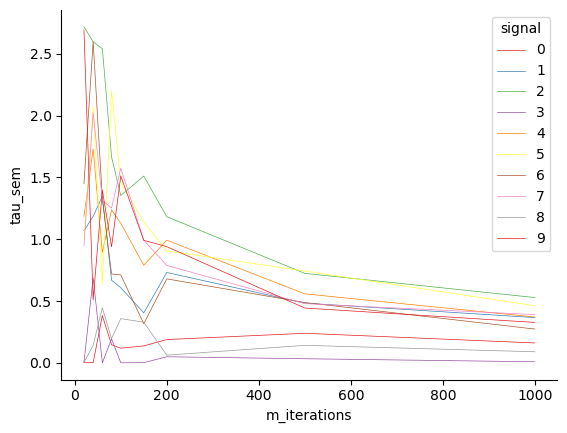

In [29]:
sns.lineplot(data=tau_df, x="m_iterations", y="tau_sem", hue="signal", palette="Set1", lw=0.5)

sns.despine()